# Final Project - Image Captioning
Apply two different approaches, CNN + LSTM and ResNet + GRU, to automatically generate captions for images. Use Flickr 8k Dataset and pretrained deep models, as needed, to demonstrate the approaches. You must compare the performances of the two approaches by computing their BLEU scores.
## CNN + LSTM

In [1]:
import numpy as np
from glob import glob
import cv2
import tensorflow as tf
import visualkeras
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as lay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GRU, RepeatVector, TimeDistributed
import os
import matplotlib.pyplot as plt

In [2]:
images_path = r'E:\NEU\Courses\22Spring\INFO7375_ST in AI\Final_Project_Zifeng_Jiang\Images\*.jpg'
images = glob(images_path)

caption_path = 'captions.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')
captions = captions[1:]

In [3]:
# This variable is how many images that we will work on ( you can use the full dataset if you have good gpu and ram)
samp = 1500

In [4]:
from tensorflow.keras.applications import VGG16

# load vgg16 model
cnn = VGG16()
# restructure the model
cnn = Model(inputs = cnn.inputs, outputs = cnn.layers[-2].output)
# summarize
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Data Preprocessing and feature extraction

In [5]:
# Reading the images and extract the features
imgs = {}
l = 0
for i in images:
    if l == samp:
        break
    k = i.split('\\')[-1]

    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.reshape(1,224,224,3)
    pred = cnn.predict(img).reshape(4096,)

    imgs[k] = pred
    l += 1

In [6]:
caps = {}
for cap in captions:
    try:
        a = cap.split(',')
        path = a[0]
        cape = a[1][:-2]
    except:
        continue
    
    if path in imgs:
        if path not in caps:
            caps[path] = [cape]
        else:
            caps[path].append(cape)

In [7]:
caps

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way',
  'A girl going into a wooden building',
  'A little girl climbing into a wooden playhouse',
  'A little girl climbing the stairs to her playhouse',
  'A little girl in a pink dress going into a wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighti',
  'A black dog and a tri-colored dog playing with each other on the road',
  'A black dog and a white dog with brown spots are staring at each other in the street',
  'Two dogs of different breeds looking at each other on the road',
  'Two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
  'A little girl is sitting in front of a large painted rainbow',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
  'There is a girl with pigtai

In [8]:
for i,c in caps.items():
    for cc in range(len(c)):
        p = c[cc].lower()
        k = '<sos> ' + p + ' <eos>'
        caps[i][cc] = k

In [9]:
# making a vocabulary dictionary with position
vacob ={}
for i,c in caps.items():
    for cc in range(len(c)):
        words = caps[i][cc].split()
        for w in words:
            if w not in vacob:
                vacob[w] = len(vacob) + 1

In [10]:
vacob

{'<sos>': 1,
 'a': 2,
 'child': 3,
 'in': 4,
 'pink': 5,
 'dress': 6,
 'is': 7,
 'climbing': 8,
 'up': 9,
 'set': 10,
 'of': 11,
 'stairs': 12,
 'an': 13,
 'entry': 14,
 'way': 15,
 '<eos>': 16,
 'girl': 17,
 'going': 18,
 'into': 19,
 'wooden': 20,
 'building': 21,
 'little': 22,
 'playhouse': 23,
 'the': 24,
 'to': 25,
 'her': 26,
 'cabin': 27,
 'black': 28,
 'dog': 29,
 'and': 30,
 'spotted': 31,
 'are': 32,
 'fighti': 33,
 'tri-colored': 34,
 'playing': 35,
 'with': 36,
 'each': 37,
 'other': 38,
 'on': 39,
 'road': 40,
 'white': 41,
 'brown': 42,
 'spots': 43,
 'staring': 44,
 'at': 45,
 'street': 46,
 'two': 47,
 'dogs': 48,
 'different': 49,
 'breeds': 50,
 'looking': 51,
 'pavement': 52,
 'moving': 53,
 'toward': 54,
 'covered': 55,
 'paint': 56,
 'sits': 57,
 'front': 58,
 'painted': 59,
 'rainbow': 60,
 'hands': 61,
 'bowl': 62,
 'sitting': 63,
 'large': 64,
 'small': 65,
 'grass': 66,
 'plays': 67,
 'fingerpaints': 68,
 'canvas': 69,
 'it': 70,
 'there': 71,
 'pigtails': 72,

In [11]:
for i,c in caps.items():
    for cc in range(len(c)):
        words = caps[i][cc].split()
        encoded = []
        for w in words:
            encoded.append(vacob[w])
        caps[i][cc] = encoded

In [12]:
m = 0
for i,c in caps.items():
    for cc in c:
        if m < len(cc):
            m = len(cc)

In [13]:
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [14]:
x_img = []
yin = []
yout = []

for i,c in caps.items():
    for c2 in c:
        for g in range(1,len(c2)):
            yi = [c2[:g]]
            yo = c2[g]

            in_seq = pad_sequences(yi, maxlen = m, padding = 'post', truncating = 'post')[0]
            out_seq = to_categorical([yo], num_classes = len(vacob) + 1)[0]

            x_img.append(imgs[i])
            yin.append(in_seq)
            yout.append(out_seq)

In [15]:
x_in = np.array(x_img)
y_in = np.array(yin)
y_out = np.array(yout)

In [16]:
print(x_in.shape,y_in.shape,y_out.shape)

(86349, 4096) (86349, 35) (86349, 4319)


In [17]:
inputs1 = Input(shape=(4096,))
drop_1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(drop_1)

inputs2 = Input(shape=(m,))
embed1 = Embedding(input_dim = len(vacob) + 1, output_dim = 128, input_length = m, mask_zero=True)(inputs2)
drop_2 = Dropout(0.5)(embed1)
se3 = LSTM(256)(drop_2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vacob) + 1, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 128)      552832      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [19]:
model.fit([x_in, y_in], y_out, batch_size = 32, epochs = 100)

Epoch 1/100
2699/2699 [==============================] - 20s 6ms/step - loss: 4.5814 - accuracy: 0.2464
Epoch 2/100
2699/2699 [==============================] - 16s 6ms/step - loss: 3.7948 - accuracy: 0.3122
Epoch 3/100
2699/2699 [==============================] - 16s 6ms/step - loss: 3.5152 - accuracy: 0.3321
Epoch 4/100
2699/2699 [==============================] - 16s 6ms/step - loss: 3.3298 - accuracy: 0.3427
Epoch 5/100
2699/2699 [==============================] - 16s 6ms/step - loss: 3.1802 - accuracy: 0.3527
Epoch 6/100
2699/2699 [==============================] - 16s 6ms/step - loss: 3.0697 - accuracy: 0.3615
Epoch 7/100
2699/2699 [==============================] - 16s 6ms/step - loss: 2.9622 - accuracy: 0.3684
Epoch 8/100
2699/2699 [==============================] - 16s 6ms/step - loss: 2.8815 - accuracy: 0.3744
Epoch 9/100
2699/2699 [==============================] - 16s 6ms/step - loss: 2.8102 - accuracy: 0.3802
Epoch 10/100
2699/2699 [==============================] - 16s 6m

2699/2699 [==============================] - 18s 7ms/step - loss: 1.7598 - accuracy: 0.5376
Epoch 80/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7663 - accuracy: 0.5352
Epoch 81/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7581 - accuracy: 0.5391
Epoch 82/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7514 - accuracy: 0.5397
Epoch 83/100
2699/2699 [==============================] - 18s 7ms/step - loss: 1.7569 - accuracy: 0.5392
Epoch 84/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7505 - accuracy: 0.5407
Epoch 85/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7454 - accuracy: 0.5428
Epoch 86/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7502 - accuracy: 0.5404
Epoch 87/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7474 - accuracy: 0.5412
Epoch 88/100
2699/2699 [==============================] - 17s 6ms/st

In [20]:
inv_vacob = {v:k for k, v in vacob.items()}

 a man in a brown shirt and a little boy wearing a black shirt and red shorts in a hawaiin


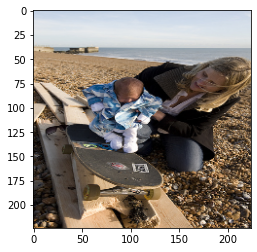

In [21]:
h = 1234
path_img = images[h]
test = cv2.imread(path_img)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (224,224))
test = test.reshape(1,224,224,3)
predt = cnn.predict(test).reshape(1,4096)

word = ['<sos>']
word_encoded = []
stement = ''
for i in range(20):
    word_encoded = []
    for w in word:
        word_encoded.append(vacob[w])


    encoded = [word_encoded]
    encoded = pad_sequences(encoded, padding = 'post', truncating = 'post', maxlen = m)

    prediction = np.argmax(model.predict([predt, encoded]))

    sampled_word = inv_vacob[prediction]
    if sampled_word == '<eos>':
        break

    word.append(sampled_word)
    stement += ' ' + sampled_word

plt.imshow(test.reshape(224,224,3))
print(stement)

## BLEU Score Explaination:

The BLEU score compares a sentence against one or more reference sentences and tells how well does the candidate sentence matched the list of reference sentences. It gives an output score between 0 and 1.

A BLEU score of 1 means that the candidate sentence perfectly matches one of the reference sentences.

This score is a common metric of measurement for Image captioning models.

**BLEU-n** is just the geometric average of the n-gram precision.

For example, **BLEU-1** is simply the **unigram precision**, **BLEU-2** is the **geometric average of unigram and bigram precision**, **BLEU-3** is the **geometric average of unigram, bigram, and trigram precision** and so on.

Having said that, if you want to compute specific **n-gram BLEU scores**, you have to pass a weights parameter when you call **corpus_bleu** . Note that if you ignore passing this weights parameter, then by default BLEU-4 scores are returned, which is what happening in the evaluation here.

In [22]:
from nltk.translate.bleu_score import sentence_bleu

In [23]:
allcaps = {}
for cap in captions:
    try:
        a = cap.split(',')
        path = a[0]
        cape = a[1][:-2]
    except:
        continue
    
    if path not in allcaps:
        allcaps[path] = [cape]
    else:
        allcaps[path].append(cape)

In [24]:
for cap in allcaps:
    if cap == images[h].split('\\')[-1]:
        refsent = allcaps[cap]

In [25]:
candidate = stement[1:]
reference = []
for ref in refsent:
    reference.append(ref.split())

reference

[['A',
  'woman',
  'holding',
  'and',
  'posing',
  'an',
  'infant',
  'dressed',
  'in',
  'a',
  'hawaiin',
  'shirt',
  'on',
  'a',
  'skateboard'],
 ['a',
  'woman',
  'holds',
  'a',
  'small',
  'baby',
  'on',
  'a',
  'skateboard',
  'at',
  'the',
  'bea'],
 ['A',
  'woman',
  'holds',
  'a',
  'small',
  'infant',
  'over',
  'a',
  'skateboard',
  'at',
  'the',
  'beach'],
 ['a',
  'woman',
  'in',
  'a',
  'brown',
  'coat',
  'places',
  'a',
  'baby',
  'on',
  'a',
  'skateboard',
  'that',
  'is',
  'on',
  'a',
  'wooden',
  'runway',
  'on',
  'the',
  'beach'],
 ['A',
  'woman',
  'placing',
  'a',
  'baby',
  'on',
  'a',
  'skateboard',
  'on',
  'the',
  'beach']]

In [26]:
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
#print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
#print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
#print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

BLEU score -> 8.869585468237212e-232
Individual 1-gram: 0.056180


E:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
